# Parameter Extraction for EGL-36 Ion Channel

In [1]:
"""
Example of using cwFitter to generate a HH model for EGL-36 ion channel
Based on experimental data from doi:10.1016/S0896-6273(00)80355-4
"""

import os.path
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
from channelworm.fitter import *

In [2]:
cwd=os.getcwd()
path = cwd+'/egl-36-data/boltzmannFit/'
if not os.path.exists(path):
  os.makedirs(path)

pov_id = 11
vc_id = 12

args = {'weight':{'start':1,'peak':1,'tail':1,'end':1}}
sampleData = {}
myInitiator = initiators.Initiator()
print 'Sample Data:'
sampleData['POV'] = myInitiator.get_graphdata_from_db(pov_id,plot=False)
print 'POV'
sampleData['VClamp'] = myInitiator.get_graphdata_from_db(vc_id, plot=False)
print 'VClamp'

Sample Data:
POV
VClamp


In [3]:
scale = False
bio_params = myInitiator.get_bio_params()
sim_params = myInitiator.get_sim_params()
myEvaluator = evaluators.Evaluator(sampleData,sim_params,bio_params,scale=scale,args=args)

print 'Scale: %s'%scale
print 'args:'
print args

Scale: False
args:
{'weight': {'start': 1, 'tail': 1, 'end': 1, 'peak': 1}}


In [4]:
# bio parameters for EGL-36
bio_params['cell_type'] = 'Xenopus oocytes'
bio_params['channel_type'] = 'EGL-36'
bio_params['ion_type'] = 'K'
bio_params['val_cell_params'][0] = 200e-9 # C_mem DOI: 10.1074/jbc.M605814200
bio_params['val_cell_params'][1] = 20e-6 # area DOI: 10.1101/pdb.top066308
bio_params['gate_params'] = {'vda': {'power': 1},'cd': {'power': 1}}

print 'Gate_params:'
print bio_params['gate_params']

Gate_params:
{'vda': {'power': 1}, 'cd': {'power': 1}}


In [5]:
bio_params['channel_params'] = ['g_dens','e_rev']
bio_params['unit_chan_params'] = ['S/m2','V']
bio_params['min_val_channel'] = [1 , -150e-3]
bio_params['max_val_channel'] = [10, 150e-3]

bio_params['channel_params'].extend(['v_half_a','k_a','T_a'])
bio_params['unit_chan_params'].extend(['V','V','s'])
bio_params['min_val_channel'].extend([-0.15, 0.001, 0.001])
bio_params['max_val_channel'].extend([ 0.15,   0.1, 1])

# # #Parameters for Ca-dependent inactivation (Boyle & Cohen 2008)
bio_params['channel_params'].extend(['ca_half','alpha_ca','k_ca','T_ca'])
bio_params['unit_chan_params'].extend(['M','','M','s'])
bio_params['min_val_channel'].extend([1e-10,0.1, -1e-6, 1e-4])
bio_params['max_val_channel'].extend([1e-6 , 1 , -1e-9, 1])

# TODO: Separate simulator protocols from plot

# Simulation parameters for EGL-36 VClamp and POV
sim_params['v_hold'] = -90e-3
sim_params['I_init'] = 0
sim_params['pc_type'] = 'VClamp'
sim_params['deltat'] = 1e-4
sim_params['duration'] = 1.2
sim_params['start_time'] = 0.045
sim_params['end_time'] = 1.055
sim_params['protocol_start'] = -90e-3
sim_params['protocol_end'] = 90e-3
sim_params['protocol_steps'] = 10e-3
sim_params['ca_con'] = 1e-6

print 'Sim_params:'
print sim_params

# opt = '-pso'
# opt = '-ga'
# opt = 'leastsq'
# If no optimzation method is specified, the best candidate is hard coded.  See the next cell.  
opt = None
print 'Optimization method: ' + str(opt)

Sim_params:
{'I_init': 0, 'deltat': 0.0001, 'protocol_steps': 0.01, 'ion_type': 'Ca', 'start_time': 0.045, 'v_hold': -0.09, 'v_init': -0.075, 'ca_con': 1e-06, 'pc_type': 'VClamp', 'end_time': 1.055, 'duration': 1.2, 'protocol_end': 0.09, 'protocol_start': -0.09}
Optimization method: None


In [6]:
if len(sys.argv) == 2:
    opt = sys.argv[1]

start = time.time()

# Genetic Algorithm
if opt == '-ga':
    opt_args = myInitiator.get_opt_params()
    opt_args['max_evaluations'] = 300
    opt_args['population_size'] = 600
    # opt_args['verbose'] = False
    best_candidate, score = myEvaluator.ga_evaluate(min=bio_params['min_val_channel'],
                                                        max=bio_params['max_val_channel'],
                                                        args=opt_args)

# Particle Swarm Optimization    
elif opt == '-pso':
    opt_args = myInitiator.get_opt_params(type='PSO')
    opt_args['minstep'] = 1e-18
    opt_args['minfunc'] = 1e-18
    opt_args['swarmsize'] = 500
    opt_args['maxiter'] = 100
    opt_args['POV_dist'] = 4e-4
    best_candidate, score = myEvaluator.pso_evaluate(lb=bio_params['min_val_channel'],
                                                         ub=bio_params['max_val_channel'],
                                                         args=opt_args)

# Hard Coded Values from Past Simulation    
# GS 6/5/2018: Would be nice to know where these came from, i.e. was it simply this script with 
# one of the above algorithms, or something else
else:
    opt_args = {}
    # vda,cd *******
    best_candidate = [  3.00231776e+00,  -9.00073633e-02,   6.02673501e-02,   1.95933741e-02,
                            2.53990016e-02,   1.00000000e-9,   8.18616232e-01,  -3.29244576e-08,
                            2.42556384e-01] # 7.85842303587e-15

if opt_args:
    print 'Optimization parameters:'
    print opt_args

if opt == 'leastsq':

    # best_candidate = np.asarray(bio_params['min_val_channel']) + np.asarray(bio_params['max_val_channel']) / 2
    best_candidate_params = dict(zip(bio_params['channel_params'],best_candidate))
    cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))

    # sim_params['protocol_start'] = 10e-3
    # sim_params['protocol_end'] = 70e-3

    # vcSim = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'],act_fit=True)
    vcSim = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
    vcEval =  evaluators.Evaluator(sampleData,sim_params,bio_params,scale=scale)

    # args['weight'] = {'POV':10}
    args['weight'] = {}
    args['ftol'] = 1e-14
    # args['xtol'] = 1e-14
    # args['full_output'] = 1

    result = vcSim.vclamp_leastsq(params= bio_params['channel_params'],
                                           best_candidate= best_candidate,
                                           sampleData=sampleData,args=args)
    print 'Optimized using Scipy leastsq:'
    print result
    print 'Full output:'
    print result
    print 'leastsq Parameters:'
    print args
    best_candidate = result

    if 'POV' in sampleData:
        POV_fit_cost = vcEval.pov_cost(result)
        print 'POV cost:'
        print POV_fit_cost
    VClamp_fit_cost = vcEval.vclamp_cost(result)
    print 'VClamp cost:'
    print VClamp_fit_cost

if opt == None:
    print('No optimzation method was used.  Best candidate values hard coded.')
elif opt == 'ga':
    print('Optimzation performed with genetic algorithms')
elif opt == 'pso':
    print('Optimzation performed with particle swarm based techniques.')
elif opt == 'leastsq':
    print('Optimzation performed with least squares.')
    
secs = time.time()-start
print("----------------------------------------------------\n\n"
      +"Ran in %f seconds (%f mins)\n"%(secs, secs/60.0))

No optimzation method was used.  Best candidate values hard coded.
----------------------------------------------------

Ran in 0.000950 seconds (0.000016 mins)



### _Best candidate values used below are hard coded (see above)_

In [7]:
best_candidate_params = dict(zip(bio_params['channel_params'],best_candidate))
cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))
print 'best candidate after optimization:'
print best_candidate_params

best candidate after optimization:
{'ca_half': 1e-09, 'T_a': 0.0253990016, 'k_ca': -3.29244576e-08, 'alpha_ca': 0.818616232, 'k_a': 0.0195933741, 'v_half_a': 0.0602673501, 'g_dens': 3.00231776, 'e_rev': -0.0900073633, 'T_ca': 0.242556384}


In [8]:
mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'],act_fit=True)
mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
bestSim = mySimulator.patch_clamp()

In [10]:
myModelator = modelators.Modelator(bio_params,sim_params)

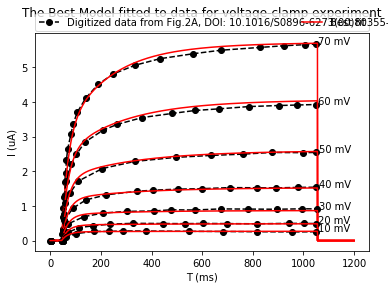

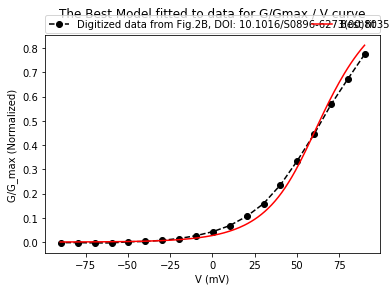

<module 'matplotlib.pyplot' from '/Users/gopalsarma/anaconda/envs/py35/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [16]:
myModelator.compare_plots(sampleData,bestSim,show=True, path=path)

In [12]:
myModelator.patch_clamp_plots(bestSim,show=True, path=path)

ValueError: Invalid RGBA argument: array([[0.28719157],
       [0.40084588],
       [0.6514793 ]])

ValueError: Invalid RGBA argument: array([[0.28719157],
       [0.40084588],
       [0.6514793 ]])

<Figure size 432x288 with 1 Axes>

In [13]:
# # Decreasing voltage steps for pretty gating plots
sim_params['protocol_steps'] = 1e-3
# # sim_params['deltat'] = 1e-5
mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
bestSim = mySimulator.patch_clamp()

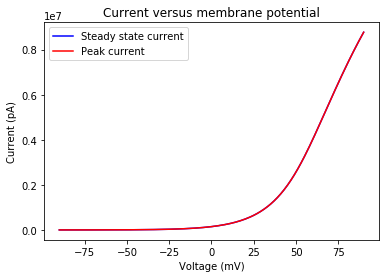

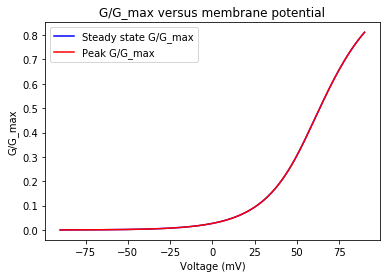

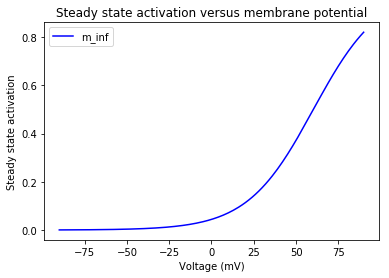

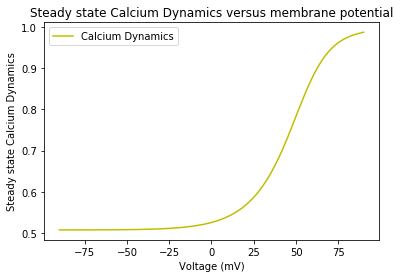

<module 'matplotlib.pyplot' from '/Users/gopalsarma/anaconda/envs/py35/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [14]:
#
myModelator = modelators.Modelator(bio_params,sim_params)
myModelator.gating_plots(bestSim, show=True, path=path)

{'model_id': 3, 'contributors': [{'name': 'Vahid Ghayoomi', 'email': 'vahidghayoomi@gmail.com'}], 'channel_id': '35', 'file_name': '/Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/egl-36-data/boltzmannFit/EGL-36.channel.nml', 'channel_name': 'EGL36', 'references': [{'PMID': '9247271', 'doi': '10.1016/S0896-6273(00)80355-4', 'citation': 'Behavioral defects in C. elegans egl-36 mutants result from potassium channels shifted in voltage-dependence of activation. (Johnstone DB; Wei A; Butler A; Salkoff L; Thomas JH. Neuron, 19(1):151-64)'}]}
Unknown cell_type: Xenopus oocytes
Currently unknown: <<<Unknown cell_type: Xenopus oocytes
>>>
Written NeuroML 2 channel file to: /Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/egl-36-data/boltzmannFit/EGL-36.channel.nml
Validating /Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/egl-36-data/boltzmannFit/EGL-36.channel.nml against /Users/gopalsarma/git/openworm_base/Cha

/Users/gopalsarma/anaconda/envs/py35/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


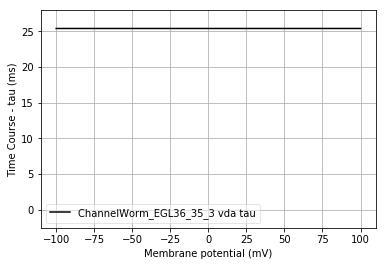

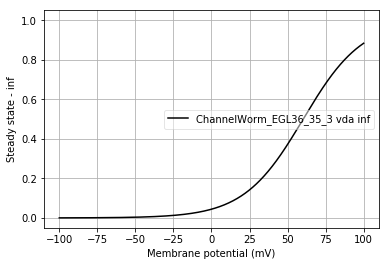

In [15]:
# Generate NeuroML2 file
contributors = [{'name': 'Vahid Ghayoomi','email': 'vahidghayoomi@gmail.com'}]
model_params = myInitiator.get_modeldata_from_db(fig_id=vc_id,model_id=3,contributors=contributors,file_path=path)
print model_params

nml2_file = myModelator.generate_channel_nml2(bio_params,best_candidate_params,model_params)
run_nml_out = myModelator.run_nml2(model_params['file_name'])